In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai import * 
from fastai.text import *
from pathlib import Path 
from tqdm import tqdm
tqdm.pandas(desc="my bar!")

In [3]:
pip install torchtext

Note: you may need to restart the kernel to use updated packages.


In [4]:
import torchtext
from torchtext.data import Iterator, BucketIterator
from torchvision import transforms, utils


In [5]:
from sklearn.metrics import confusion_matrix, f1_score, auc, roc_curve

In [6]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [7]:
from sklearn.metrics import f1_score

In [8]:
path = Config.data_path()
path.mkdir(parents=True, exist_ok=True)

path.ls()

In [9]:
df_train = pd.read_csv(path/'train.csv')
df_test = pd.read_csv(path/'test.csv')
# df_train
print(df_train.shape)
print(len(df_train))

(1306122, 3)
1306122


In [10]:
import string
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]



mispell_dict = {"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
"tryin'":"trying"}

def clean_numbers(x):
    x = re.sub('[0-9]{5,}', '#####', x)
    x = re.sub('[0-9]{4}', '####', x)
    x = re.sub('[0-9]{3}', '###', x)
    x = re.sub('[0-9]{2}', '##', x)
    return x

def mispelled_words(mispell_dict):
    mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))
    return mispell_dict, mispell_re

mispellings, mispellings_re = mispelled_words(mispell_dict)

def replace_typical_mispell(text):
    def replace(match):
        return mispellings[match.group(0)]
    return mispellings_re.sub(replace,text)

def clean_text(x):

    x = str(x)
    for punct in puncts:
        x.translate(str.maketrans('', '', string.punctuation))
    return x



In [11]:
len(df_train)


1306122

In [12]:
df_train["question_text"] = df_train["question_text"].str.lower()
df_test["question_text"] = df_test["question_text"].str.lower()

df_train['question_text'] = df_train['question_text'].progress_apply(lambda x: clean_text(x))
df_test['question_text'] = df_test['question_text'].progress_apply(lambda x: clean_text(x))

df_train['question_text'] = df_train['question_text'].progress_apply(lambda x: clean_numbers(x))
df_test['question_text'] = df_test['question_text'].progress_apply(lambda x:clean_numbers(x))

df_train['question_text'] = df_train['question_text'].progress_apply(lambda x: replace_typical_mispell(x))
df_test['question_text'] = df_test['question_text'].progress_apply(lambda x: replace_typical_mispell(x))

train_x = df_train['question_text'].fillna('_##_').values
test_x = df_test['question_text'].fillna('_##_').values

my bar!: 100%|██████████| 375806/375806 [00:05<00:00, 70829.29it/s]


import zipfile
zf = zipfile.ZipFile(path/'test.csv.zip')
df_test = pd.read_csv(zf.open('test.csv'))
zf = zipfile.ZipFile(path/'train.csv.zip')
df_train = pd.read_csv(zf.open('train.csv'))



In [55]:
# print(df_train.head(3))
print(df_test.head(3))


                    qid                                      question_text
0  0000163e3ea7c7a74cd7  why do so many women become so rude and arroga...
1  00002bd4fb5d505b9161  when should i apply for rv college of engineer...
2  00007756b4a147d2b0b3  what is it really like to be a nurse practitio...


In [13]:
train_length = len(df_train)
print(train_length)
train_length*0.80 

1306122


1044897.6000000001

In [102]:
def prepare_sequences():
    tokenizer = lambda text: text.split() # the function above is the function we will be using to tokenize the text
    TEXT = torchtext.data.Field(sequential=True, tokenize=tokenizer, lower=True)
    LABEL = torchtext.data.Field(sequential=False, use_vocab=False) # sequential and use_vocab=False since no text (binary)
    train_datafields = [("qid", None), ("question_text", TEXT), ("target", LABEL)]
    train = torchtext.data.TabularDataset( # If we had a validation set as well, we would add an additional .splits(...)
                        # path="data/train_cleaned_v2.csv", # the root directory where the data lies
                        path = "/Users/caitlinaspinall/.fastai/data/train.csv",
                        format='csv',
                        # if your csv header has a header, make sure to pass this to ensure it doesn't get proceesed as data!
                        skip_header=True, 
                        fields=train_datafields)
    test_datafields = [("qid", None),
                     ("question_text", TEXT)] 
    test = torchtext.data.TabularDataset( 
                path="/Users/caitlinaspinall/.fastai/data/test.csv",
                format="csv",
                skip_header=True,
                fields=test_datafields)
    return TEXT, LABEL, train, test
# Chat Conversation End
# Type a message...



In [103]:
TEXT,LABEL,train,test = prepare_sequences()


In [16]:
TEXT.build_vocab(train, test, vectors = "glove.6B.100d")

In [17]:

val,_ = train.split(0.2)


train,__ = train.split(0.1)

In [ ]:

from torchtext.data import Iterator, BucketIterator
train_iter = BucketIterator(
    train, # we pass in the datasets we want the iterator to draw data from
    batch_size=64, 
    sort_key= lambda x: len(x.question_text), # the BucketIterator needs to be told what function it should use to group the data.
    sort_within_batch=False, # sorting would add bias
    repeat=False)
test_iter = Iterator(test, batch_size = 64, device = None, sort = False,  sort_within_batch = False, repeat = False) #Changed device from -1 to None
val_iter = Iterator(val, batch_size = 64, device = None, sort = False,  sort_within_batch = False, repeat = False)

In [101]:
# print(iter(train_iter).__next__().question_text)
# iter(train_iter).__next__().question_text.shape

# print(iter(train_iter).__next__().target)
print(iter(test_iter).__next__().question_text)
# print(iter(val_iter).__next__().question_text)
print(type(test_iter))
print(type(train_iter))

['why', 'do', 'bengali', 'and', 'kolkata', 'people', 'dominate', 'hindi', 'language', 'speaking', 'people', 'from', 'delhi,', 'mumbai', 'and', 'other', 'parts', 'of', 'india?']
<class 'generator'>
<class 'torchtext.data.iterator.BucketIterator'>


In [20]:
target_train = iter(train_iter).__next__().target

In [65]:
print(len(val))
print(len(test))
print(len(train))
print(iter(val_iter).__next__().question_text)
iter(test_iter).__next__().question_text

261224
375806
1306122
['is', 'education', 'really', 'making', 'good', 'people', 'nowadays?']


['whats', 'a', '1788', 'new', 'hampshire', 'quarter', 'worth?']

In [22]:
TEXT.vocab.vectors.shape

torch.Size([527626, 100])

In [66]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet,self).__init__()
        hidden_size = 64
        self.embedding = nn.Embedding(len(TEXT.vocab),100)

        self.embedding.weight = nn.Parameter(TEXT.vocab.vectors)
        self.lstm = nn.LSTM(100,hidden_size, bidirectional = True, batch_first = True)
       
        self.linear = nn.Linear(hidden_size * 2 , 1)
        self.relu = nn.ReLU()
        self.out = nn.Linear(16,1)
       
    def forward(self,train):
        h_embedding = self.embedding(train)
#         h_embedding = torch.squeeze(self.embedding_dropout(torch.unsqueeze(h_embedding,0)))
        print(h_embedding.shape)    
#         print(h_embedding.shape)  
        h_lstm, _ = self.lstm(h_embedding)
        avg_pool = torch.mean(h_lstm,0)
        print(h_lstm.shape)   
#         avg_pool = torch.mean(h_lstm,1)
#         print(avg_pool.shape)
#         max_pool,_ = torch.max(h_lstm,1)
        
#         conc = torch.cat((avg_pool, max_pool),1)
#         print(conc.shape)
        conc = self.relu(self.linear(avg_pool))
        print(conc.shape)
    
#         out = self.out(conc)
        out = nn.Sigmoid()(conc)
        print(out.shape)
        return out
            
            
batch = next(iter(train_iter)).question_text 
net = NeuralNet()  
net(batch).shape

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [24]:
batch = iter(train_iter).__next__()
train_batch, class_vector = batch.question_text.transpose(0,1),batch.target.unsqueeze(1)
print(torch.max(class_vector,1)[0].shape)

torch.Size([64])


In [30]:
def weight_init(m):
    if  isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data)
        m.bias.data.zero_()
model = NeuralNet()
model.apply(weight_init)

NeuralNet(
  (embedding): Embedding(527626, 100)
  (lstm): LSTM(100, 64, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
  (out): Linear(in_features=16, out_features=1, bias=True)
)

torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([6

tensor(0.6931, grad_fn=<SumBackward0>)
46 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
47 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
48 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
49 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
50 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([47, 64, 100])
torch.Size([47, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
51 out of:  20409  With Loss of:  0.69314

tensor(0.6931, grad_fn=<SumBackward0>)
91 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
92 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
93 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
94 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([26, 64, 100])
torch.Size([26, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
95 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
96 out of:  20409  With Loss of:  0.69314

tensor(0.6931, grad_fn=<SumBackward0>)
136 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
137 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
138 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
139 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
140 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
141 out of:  20409  With Loss of:  0

tensor(0.6931, grad_fn=<SumBackward0>)
181 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([49, 64, 100])
torch.Size([49, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
182 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
183 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
184 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([25, 64, 100])
torch.Size([25, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
185 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
186 out of:  20409  With Loss of:  0

tensor(0.6931, grad_fn=<SumBackward0>)
226 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
227 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
228 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
229 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([48, 64, 100])
torch.Size([48, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
230 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
231 out of:  20409  With Loss of:  0

tensor(0.6931, grad_fn=<SumBackward0>)
271 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
272 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
273 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
274 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
275 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([26, 64, 100])
torch.Size([26, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
276 out of:  20409  With Loss of:  0

tensor(0.6931, grad_fn=<SumBackward0>)
316 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
317 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
318 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
319 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
320 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
321 out of:  20409  With Loss of:  0

tensor(0.6931, grad_fn=<SumBackward0>)
361 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
362 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
363 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
364 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
365 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
366 out of:  20409  With Loss of:  0

tensor(0.6931, grad_fn=<SumBackward0>)
406 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
407 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
408 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
409 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([23, 64, 100])
torch.Size([23, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
410 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
411 out of:  20409  With Loss of:  0

tensor(0.6931, grad_fn=<SumBackward0>)
451 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
452 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
453 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
454 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
455 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
456 out of:  20409  With Loss of:  0

tensor(0.6931, grad_fn=<SumBackward0>)
496 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
497 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
498 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
499 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
500 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
501 out of:  20409  With Loss of:  0

tensor(0.6931, grad_fn=<SumBackward0>)
541 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
542 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
543 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
544 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
545 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
546 out of:  20409  With Loss of:  0

tensor(0.6931, grad_fn=<SumBackward0>)
586 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
587 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
588 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
589 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
590 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
591 out of:  20409  With Loss of:  0

tensor(0.6931, grad_fn=<SumBackward0>)
631 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
632 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
633 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
634 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
635 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
636 out of:  20409  With Loss of:  0

tensor(0.6931, grad_fn=<SumBackward0>)
676 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
677 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
678 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
679 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([50, 64, 100])
torch.Size([50, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
680 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
681 out of:  20409  With Loss of:  0

torch.Size([51, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
721 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([24, 64, 100])
torch.Size([24, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
722 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
723 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
724 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
725 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.

tensor(0.6931, grad_fn=<SumBackward0>)
765 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
766 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
767 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
768 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
769 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
770 out of:  20409  With Loss of:  0

tensor(0.6931, grad_fn=<SumBackward0>)
810 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
811 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
812 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
813 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
814 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
815 out of:  20409  With Loss of:  0

tensor(0.6931, grad_fn=<SumBackward0>)
855 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
856 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
857 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
858 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
859 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
860 out of:  20409  With Loss of:  0

tensor(0.6931, grad_fn=<SumBackward0>)
900 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
901 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
902 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
903 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
904 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
905 out of:  20409  With Loss of:  0

tensor(0.6931, grad_fn=<SumBackward0>)
945 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
946 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
947 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
948 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
949 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
950 out of:  20409  With Loss of:  0

tensor(0.6931, grad_fn=<SumBackward0>)
990 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
991 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
992 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
993 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
994 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
995 out of:  20409  With Loss of:  0

tensor(0.6931, grad_fn=<SumBackward0>)
1035 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1036 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1037 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1038 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1039 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1040 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
1080 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1081 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1082 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1083 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1084 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1085 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
1125 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1126 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1127 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1128 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([47, 64, 100])
torch.Size([47, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1129 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1130 out of:  20409  With Loss 

torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1170 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1171 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1172 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1173 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([47, 64, 100])
torch.Size([47, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1174 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tens

tensor(0.6931, grad_fn=<SumBackward0>)
1214 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1215 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1216 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([27, 64, 100])
torch.Size([27, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1217 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1218 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1219 out of:  20409  With Loss 

torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1259 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1260 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1261 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1262 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1263 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBac

tensor(0.6931, grad_fn=<SumBackward0>)
1303 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1304 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1305 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1306 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1307 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([51, 64, 100])
torch.Size([51, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1308 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
1348 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1349 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1350 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1351 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1352 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1353 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
1393 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1394 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1395 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1396 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1397 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1398 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
1438 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1439 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1440 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1441 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1442 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1443 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
1483 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1484 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1485 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1486 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1487 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1488 out of:  20409  With Loss 

torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1528 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1529 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1530 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([47, 64, 100])
torch.Size([47, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1531 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1532 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tens

tensor(0.6931, grad_fn=<SumBackward0>)
1572 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([52, 64, 100])
torch.Size([52, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1573 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1574 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1575 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1576 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1577 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
1617 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1618 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1619 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1620 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([47, 64, 100])
torch.Size([47, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1621 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1622 out of:  20409  With Loss 

torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1662 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([47, 64, 100])
torch.Size([47, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1663 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1664 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1665 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1666 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tens

tensor(0.6931, grad_fn=<SumBackward0>)
1706 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1707 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1708 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1709 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1710 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1711 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
1751 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1752 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1753 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1754 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1755 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1756 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
1796 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1797 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1798 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1799 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([25, 64, 100])
torch.Size([25, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1800 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([49, 64, 100])
torch.Size([49, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1801 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
1841 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1842 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1843 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1844 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1845 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1846 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
1886 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1887 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1888 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1889 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1890 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1891 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
1931 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([47, 64, 100])
torch.Size([47, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1932 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1933 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1934 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1935 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1936 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
1976 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1977 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1978 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1979 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1980 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
1981 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
2021 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([26, 64, 100])
torch.Size([26, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2022 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2023 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2024 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2025 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([52, 64, 100])
torch.Size([52, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2026 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
2066 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([48, 64, 100])
torch.Size([48, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2067 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2068 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([49, 64, 100])
torch.Size([49, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2069 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2070 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2071 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
2111 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2112 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([50, 64, 100])
torch.Size([50, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2113 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([26, 64, 100])
torch.Size([26, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2114 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2115 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([51, 64, 100])
torch.Size([51, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2116 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
2156 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2157 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2158 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2159 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2160 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2161 out of:  20409  With Loss 

torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2201 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([54, 64, 100])
torch.Size([54, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2202 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2203 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2204 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2205 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tens

tensor(0.6931, grad_fn=<SumBackward0>)
2245 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2246 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2247 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2248 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2249 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([49, 64, 100])
torch.Size([49, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2250 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
2290 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2291 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2292 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2293 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2294 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2295 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
2335 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2336 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2337 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([55, 64, 100])
torch.Size([55, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2338 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2339 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2340 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
2380 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2381 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2382 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2383 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2384 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2385 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
2425 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([47, 64, 100])
torch.Size([47, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2426 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2427 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([47, 64, 100])
torch.Size([47, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2428 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2429 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2430 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
2470 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2471 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2472 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([47, 64, 100])
torch.Size([47, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2473 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2474 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2475 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
2515 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2516 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2517 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2518 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2519 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2520 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
2560 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2561 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([23, 64, 100])
torch.Size([23, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2562 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2563 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([49, 64, 100])
torch.Size([49, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2564 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2565 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
2605 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([48, 64, 100])
torch.Size([48, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2606 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2607 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2608 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2609 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2610 out of:  20409  With Loss 

torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2650 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2651 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2652 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2653 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2654 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tens

tensor(0.6931, grad_fn=<SumBackward0>)
2694 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2695 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2696 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2697 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2698 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2699 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
2739 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2740 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2741 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2742 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2743 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2744 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
2784 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2785 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2786 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2787 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2788 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([48, 64, 100])
torch.Size([48, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2789 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
2829 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2830 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2831 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2832 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2833 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([48, 64, 100])
torch.Size([48, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2834 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
2874 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2875 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2876 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2877 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2878 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2879 out of:  20409  With Loss 

torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2919 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2920 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2921 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2922 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2923 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tens

tensor(0.6931, grad_fn=<SumBackward0>)
2963 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([48, 64, 100])
torch.Size([48, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2964 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2965 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2966 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2967 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
2968 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
3008 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3009 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([50, 64, 100])
torch.Size([50, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3010 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3011 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3012 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3013 out of:  20409  With Loss 

torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3053 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([47, 64, 100])
torch.Size([47, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3054 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([27, 64, 100])
torch.Size([27, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3055 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3056 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3057 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tens

tensor(0.6931, grad_fn=<SumBackward0>)
3097 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([47, 64, 100])
torch.Size([47, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3098 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3099 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3100 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3101 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3102 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
3142 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3143 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([52, 64, 100])
torch.Size([52, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3144 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3145 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([26, 64, 100])
torch.Size([26, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3146 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3147 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
3187 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([53, 64, 100])
torch.Size([53, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3188 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3189 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([47, 64, 100])
torch.Size([47, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3190 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3191 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3192 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
3232 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3233 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3234 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3235 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3236 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3237 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
3277 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([47, 64, 100])
torch.Size([47, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3278 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3279 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3280 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3281 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3282 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
3322 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3323 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3324 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3325 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3326 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3327 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
3367 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3368 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3369 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3370 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3371 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3372 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
3412 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3413 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3414 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3415 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3416 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3417 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
3457 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3458 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([49, 64, 100])
torch.Size([49, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3459 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3460 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3461 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3462 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
3502 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([27, 64, 100])
torch.Size([27, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3503 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([48, 64, 100])
torch.Size([48, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3504 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3505 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3506 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([24, 64, 100])
torch.Size([24, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3507 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
3547 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3548 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3549 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3550 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3551 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3552 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
3592 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3593 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3594 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3595 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3596 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3597 out of:  20409  With Loss 

torch.Size([47, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3637 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([52, 64, 100])
torch.Size([52, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3638 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3639 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3640 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3641 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tens

tensor(0.6931, grad_fn=<SumBackward0>)
3681 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3682 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3683 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3684 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3685 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([50, 64, 100])
torch.Size([50, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3686 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
3726 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3727 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3728 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3729 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3730 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3731 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
3771 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3772 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3773 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3774 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3775 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3776 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
3816 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3817 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3818 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3819 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3820 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3821 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
3861 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3862 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([48, 64, 100])
torch.Size([48, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3863 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3864 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3865 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3866 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
3906 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([23, 64, 100])
torch.Size([23, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3907 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([48, 64, 100])
torch.Size([48, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3908 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3909 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3910 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3911 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
3951 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([49, 64, 100])
torch.Size([49, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3952 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3953 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3954 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3955 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3956 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
3996 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3997 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3998 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
3999 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4000 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4001 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
4041 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4042 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4043 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4044 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4045 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4046 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
4086 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4087 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4088 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4089 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4090 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4091 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
4131 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([48, 64, 100])
torch.Size([48, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4132 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4133 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4134 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4135 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4136 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
4176 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4177 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4178 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4179 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4180 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4181 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
4221 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4222 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([48, 64, 100])
torch.Size([48, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4223 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4224 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4225 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4226 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
4266 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([48, 64, 100])
torch.Size([48, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4267 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4268 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([26, 64, 100])
torch.Size([26, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4269 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([27, 64, 100])
torch.Size([27, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4270 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([48, 64, 100])
torch.Size([48, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4271 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
4311 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4312 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4313 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4314 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4315 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4316 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
4356 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4357 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4358 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4359 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4360 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4361 out of:  20409  With Loss 

torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4401 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4402 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4403 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4404 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4405 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([24, 64, 100])
torch.Size([24, 64, 128])
torch.Size([64, 1]

tensor(0.6931, grad_fn=<SumBackward0>)
4445 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4446 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4447 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4448 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4449 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4450 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
4490 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4491 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4492 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4493 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4494 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4495 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
4535 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4536 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4537 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4538 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4539 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4540 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
4580 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4581 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4582 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4583 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4584 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4585 out of:  20409  With Loss 

torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4625 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4626 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4627 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4628 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4629 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tens

tensor(0.6931, grad_fn=<SumBackward0>)
4669 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4670 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4671 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4672 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4673 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4674 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
4714 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4715 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4716 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4717 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([50, 64, 100])
torch.Size([50, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4718 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4719 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
4759 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4760 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4761 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4762 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4763 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4764 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
4804 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4805 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([53, 64, 100])
torch.Size([53, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4806 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4807 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4808 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4809 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
4849 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4850 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4851 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4852 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4853 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4854 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
4894 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4895 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4896 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4897 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4898 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4899 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
4939 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([49, 64, 100])
torch.Size([49, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4940 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([26, 64, 100])
torch.Size([26, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4941 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4942 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4943 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4944 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
4984 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4985 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4986 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4987 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4988 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
4989 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
5029 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5030 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([47, 64, 100])
torch.Size([47, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5031 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5032 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5033 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5034 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
5074 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5075 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5076 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5077 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5078 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5079 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
5119 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5120 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5121 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5122 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5123 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5124 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
5164 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5165 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5166 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([23, 64, 100])
torch.Size([23, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5167 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5168 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5169 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
5209 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([51, 64, 100])
torch.Size([51, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5210 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5211 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5212 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5213 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5214 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
5254 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5255 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5256 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5257 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5258 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5259 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
5299 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5300 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5301 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5302 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5303 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5304 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
5344 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([52, 64, 100])
torch.Size([52, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5345 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5346 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5347 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([26, 64, 100])
torch.Size([26, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5348 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5349 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
5389 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5390 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5391 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5392 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5393 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5394 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
5434 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5435 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5436 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5437 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5438 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([27, 64, 100])
torch.Size([27, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5439 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
5479 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5480 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5481 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5482 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5483 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5484 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
5524 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5525 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5526 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5527 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5528 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5529 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
5569 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5570 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5571 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5572 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5573 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5574 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
5614 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([54, 64, 100])
torch.Size([54, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5615 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5616 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5617 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([48, 64, 100])
torch.Size([48, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5618 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5619 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
5659 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5660 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5661 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5662 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5663 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5664 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
5704 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5705 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5706 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5707 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5708 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5709 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
5749 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5750 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5751 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5752 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5753 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([27, 64, 100])
torch.Size([27, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5754 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
5794 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5795 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5796 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5797 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5798 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5799 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
5839 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([27, 64, 100])
torch.Size([27, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5840 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5841 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5842 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5843 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5844 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
5884 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([51, 64, 100])
torch.Size([51, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5885 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5886 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([54, 64, 100])
torch.Size([54, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5887 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5888 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5889 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
5929 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5930 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5931 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5932 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5933 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5934 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
5974 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5975 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5976 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5977 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5978 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
5979 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
6019 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6020 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6021 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6022 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6023 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6024 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
6064 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6065 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6066 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6067 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([27, 64, 100])
torch.Size([27, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6068 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6069 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
6109 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6110 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6111 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6112 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6113 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6114 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
6154 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6155 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([48, 64, 100])
torch.Size([48, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6156 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6157 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6158 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6159 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
6199 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6200 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([26, 64, 100])
torch.Size([26, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6201 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6202 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6203 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([27, 64, 100])
torch.Size([27, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6204 out of:  20409  With Loss 

torch.Size([48, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6244 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6245 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6246 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6247 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6248 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tens

tensor(0.6931, grad_fn=<SumBackward0>)
6288 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6289 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6290 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6291 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6292 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([48, 64, 100])
torch.Size([48, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6293 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
6333 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6334 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6335 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([23, 64, 100])
torch.Size([23, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6336 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6337 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6338 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
6378 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6379 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6380 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6381 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6382 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([48, 64, 100])
torch.Size([48, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6383 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
6423 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6424 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6425 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6426 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6427 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6428 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
6468 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6469 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6470 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([26, 64, 100])
torch.Size([26, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6471 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6472 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6473 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
6513 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([23, 64, 100])
torch.Size([23, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6514 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6515 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([27, 64, 100])
torch.Size([27, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6516 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6517 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6518 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
6558 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6559 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6560 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6561 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6562 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6563 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
6603 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6604 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6605 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6606 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([53, 64, 100])
torch.Size([53, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6607 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6608 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
6648 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6649 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6650 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6651 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6652 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6653 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
6693 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6694 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([27, 64, 100])
torch.Size([27, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6695 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6696 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6697 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6698 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
6738 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6739 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6740 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6741 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6742 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6743 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
6783 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6784 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6785 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6786 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6787 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6788 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
6828 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([48, 64, 100])
torch.Size([48, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6829 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([27, 64, 100])
torch.Size([27, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6830 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6831 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6832 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6833 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
6873 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([48, 64, 100])
torch.Size([48, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6874 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6875 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6876 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([53, 64, 100])
torch.Size([53, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6877 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6878 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
6918 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6919 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6920 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6921 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6922 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6923 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
6963 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6964 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([52, 64, 100])
torch.Size([52, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6965 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6966 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6967 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
6968 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
7008 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([53, 64, 100])
torch.Size([53, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7009 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7010 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7011 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7012 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7013 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
7053 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7054 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7055 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7056 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7057 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7058 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
7098 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7099 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7100 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7101 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([50, 64, 100])
torch.Size([50, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7102 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7103 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
7143 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7144 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7145 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([49, 64, 100])
torch.Size([49, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7146 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7147 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7148 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
7188 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7189 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7190 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([47, 64, 100])
torch.Size([47, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7191 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7192 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7193 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
7233 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([26, 64, 100])
torch.Size([26, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7234 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([48, 64, 100])
torch.Size([48, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7235 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([20, 64, 100])
torch.Size([20, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7236 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7237 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7238 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
7278 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7279 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7280 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7281 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7282 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7283 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
7323 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7324 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7325 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7326 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7327 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([49, 64, 100])
torch.Size([49, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7328 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
7368 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7369 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7370 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7371 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7372 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7373 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
7413 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([50, 64, 100])
torch.Size([50, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7414 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7415 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([47, 64, 100])
torch.Size([47, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7416 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7417 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7418 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
7458 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7459 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7460 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7461 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7462 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7463 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
7503 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7504 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7505 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7506 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7507 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([49, 64, 100])
torch.Size([49, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7508 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
7548 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7549 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7550 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([53, 64, 100])
torch.Size([53, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7551 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7552 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([48, 64, 100])
torch.Size([48, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7553 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
7593 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7594 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7595 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7596 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7597 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7598 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
7638 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7639 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([26, 64, 100])
torch.Size([26, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7640 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([50, 64, 100])
torch.Size([50, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7641 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7642 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7643 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
7683 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([47, 64, 100])
torch.Size([47, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7684 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7685 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7686 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7687 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7688 out of:  20409  With Loss 

torch.Size([49, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7728 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7729 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7730 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7731 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7732 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tens

tensor(0.6931, grad_fn=<SumBackward0>)
7772 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7773 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7774 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7775 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7776 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([53, 64, 100])
torch.Size([53, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7777 out of:  20409  With Loss 

torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7817 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7818 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7819 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7820 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([27, 64, 100])
torch.Size([27, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7821 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tens

tensor(0.6931, grad_fn=<SumBackward0>)
7861 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7862 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7863 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7864 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7865 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7866 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
7906 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7907 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7908 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([51, 64, 100])
torch.Size([51, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7909 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7910 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7911 out of:  20409  With Loss 

torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7951 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7952 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7953 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7954 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7955 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tens

tensor(0.6931, grad_fn=<SumBackward0>)
7995 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7996 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7997 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7998 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([47, 64, 100])
torch.Size([47, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
7999 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8000 out of:  20409  With Loss 

torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8040 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8041 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8042 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8043 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([51, 64, 100])
torch.Size([51, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8044 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tens

tensor(0.6931, grad_fn=<SumBackward0>)
8084 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([48, 64, 100])
torch.Size([48, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8085 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([27, 64, 100])
torch.Size([27, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8086 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8087 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([48, 64, 100])
torch.Size([48, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8088 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([27, 64, 100])
torch.Size([27, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8089 out of:  20409  With Loss 

torch.Size([52, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8129 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8130 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8131 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8132 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8133 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tens

tensor(0.6931, grad_fn=<SumBackward0>)
8173 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([51, 64, 100])
torch.Size([51, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8174 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8175 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8176 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8177 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8178 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
8218 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8219 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8220 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8221 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8222 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8223 out of:  20409  With Loss 

torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8263 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8264 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8265 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8266 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([47, 64, 100])
torch.Size([47, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8267 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tens

torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8307 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8308 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8309 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8310 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8311 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBac

tensor(0.6931, grad_fn=<SumBackward0>)
8351 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8352 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8353 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8354 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8355 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([27, 64, 100])
torch.Size([27, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8356 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
8396 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8397 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8398 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8399 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8400 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8401 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
8441 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8442 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8443 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8444 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8445 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([26, 64, 100])
torch.Size([26, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8446 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
8486 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8487 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([26, 64, 100])
torch.Size([26, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8488 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8489 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([47, 64, 100])
torch.Size([47, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8490 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8491 out of:  20409  With Loss 

torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8531 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8532 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8533 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8534 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8535 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tens

tensor(0.6931, grad_fn=<SumBackward0>)
8575 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8576 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8577 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8578 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([47, 64, 100])
torch.Size([47, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8579 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8580 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
8620 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8621 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8622 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([49, 64, 100])
torch.Size([49, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8623 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([26, 64, 100])
torch.Size([26, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8624 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([47, 64, 100])
torch.Size([47, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8625 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
8665 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8666 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8667 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8668 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8669 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8670 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
8710 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8711 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8712 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8713 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8714 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8715 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
8755 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8756 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8757 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8758 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8759 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8760 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
8800 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8801 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8802 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8803 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8804 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8805 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
8845 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8846 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8847 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8848 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8849 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8850 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
8890 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8891 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([27, 64, 100])
torch.Size([27, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8892 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8893 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8894 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8895 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
8935 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8936 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8937 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([50, 64, 100])
torch.Size([50, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8938 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8939 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8940 out of:  20409  With Loss 

torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8980 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([48, 64, 100])
torch.Size([48, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8981 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([48, 64, 100])
torch.Size([48, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8982 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8983 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([53, 64, 100])
torch.Size([53, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
8984 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([54, 64, 100])
torch.Size([54, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBac

tensor(0.6931, grad_fn=<SumBackward0>)
9024 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9025 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9026 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9027 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9028 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9029 out of:  20409  With Loss 

torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9069 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9070 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9071 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9072 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9073 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([49, 64, 100])
torch.Size([49, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tens

tensor(0.6931, grad_fn=<SumBackward0>)
9113 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9114 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9115 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9116 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9117 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([48, 64, 100])
torch.Size([48, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9118 out of:  20409  With Loss 

torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9158 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9159 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([54, 64, 100])
torch.Size([54, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9160 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9161 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9162 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tens

tensor(0.6931, grad_fn=<SumBackward0>)
9202 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9203 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([57, 64, 100])
torch.Size([57, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9204 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9205 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9206 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9207 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
9247 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9248 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9249 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9250 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9251 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9252 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
9292 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([25, 64, 100])
torch.Size([25, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9293 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9294 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9295 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9296 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9297 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
9337 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9338 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9339 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9340 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9341 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9342 out of:  20409  With Loss 

torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9382 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9383 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9384 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9385 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9386 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tens

tensor(0.6931, grad_fn=<SumBackward0>)
9426 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9427 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9428 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9429 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9430 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9431 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
9471 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9472 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9473 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9474 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9475 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9476 out of:  20409  With Loss 

torch.Size([49, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9516 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9517 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9518 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9519 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9520 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([49, 64, 100])
torch.Size([49, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tens

tensor(0.6931, grad_fn=<SumBackward0>)
9560 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9561 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9562 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9563 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9564 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9565 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
9605 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9606 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([48, 64, 100])
torch.Size([48, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9607 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9608 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9609 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9610 out of:  20409  With Loss 

torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9650 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9651 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9652 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9653 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9654 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tens

tensor(0.6931, grad_fn=<SumBackward0>)
9694 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9695 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9696 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9697 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9698 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9699 out of:  20409  With Loss 

torch.Size([52, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9739 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9740 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9741 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([50, 64, 100])
torch.Size([50, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9742 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9743 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([48, 64, 100])
torch.Size([48, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tens

tensor(0.6931, grad_fn=<SumBackward0>)
9783 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9784 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9785 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9786 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9787 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9788 out of:  20409  With Loss 

torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9828 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9829 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9830 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9831 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9832 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tens

tensor(0.6931, grad_fn=<SumBackward0>)
9872 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9873 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9874 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9875 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([50, 64, 100])
torch.Size([50, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9876 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9877 out of:  20409  With Loss 

torch.Size([47, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9917 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9918 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9919 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9920 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9921 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tens

tensor(0.6931, grad_fn=<SumBackward0>)
9961 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9962 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9963 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([27, 64, 100])
torch.Size([27, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9964 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([53, 64, 100])
torch.Size([53, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9965 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
9966 out of:  20409  With Loss 

tensor(0.6931, grad_fn=<SumBackward0>)
10006 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10007 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([48, 64, 100])
torch.Size([48, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10008 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([49, 64, 100])
torch.Size([49, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10009 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10010 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10011 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
10050 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10051 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10052 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10053 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10054 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([48, 64, 100])
torch.Size([48, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10055 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
10094 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10095 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10096 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10097 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10098 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10099 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
10138 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10139 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10140 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10141 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10142 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10143 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
10182 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10183 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([50, 64, 100])
torch.Size([50, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10184 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10185 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10186 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([48, 64, 100])
torch.Size([48, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10187 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
10226 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10227 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10228 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([25, 64, 100])
torch.Size([25, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10229 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10230 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10231 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
10270 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10271 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([25, 64, 100])
torch.Size([25, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10272 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10273 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10274 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10275 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
10314 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10315 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10316 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10317 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10318 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10319 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
10358 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10359 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([51, 64, 100])
torch.Size([51, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10360 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10361 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10362 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10363 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
10402 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10403 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10404 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10405 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10406 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10407 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
10446 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10447 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([24, 64, 100])
torch.Size([24, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10448 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10449 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10450 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10451 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
10490 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10491 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10492 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10493 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10494 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10495 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
10534 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10535 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10536 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10537 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10538 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10539 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
10578 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10579 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([27, 64, 100])
torch.Size([27, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10580 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10581 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10582 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10583 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
10622 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10623 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10624 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10625 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10626 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10627 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
10666 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10667 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([47, 64, 100])
torch.Size([47, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10668 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([54, 64, 100])
torch.Size([54, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10669 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10670 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10671 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
10710 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10711 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10712 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10713 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10714 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([26, 64, 100])
torch.Size([26, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10715 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
10754 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10755 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([47, 64, 100])
torch.Size([47, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10756 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10757 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10758 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10759 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
10798 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10799 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10800 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([52, 64, 100])
torch.Size([52, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10801 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10802 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10803 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
10842 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10843 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10844 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10845 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10846 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([47, 64, 100])
torch.Size([47, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10847 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
10886 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10887 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10888 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([47, 64, 100])
torch.Size([47, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10889 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([50, 64, 100])
torch.Size([50, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10890 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10891 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
10930 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10931 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10932 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10933 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10934 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([25, 64, 100])
torch.Size([25, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10935 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
10974 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10975 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10976 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10977 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10978 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
10979 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
11018 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11019 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11020 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11021 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11022 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11023 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
11062 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11063 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([27, 64, 100])
torch.Size([27, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11064 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11065 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11066 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([49, 64, 100])
torch.Size([49, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11067 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
11106 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11107 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11108 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11109 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([47, 64, 100])
torch.Size([47, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11110 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([25, 64, 100])
torch.Size([25, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11111 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
11150 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11151 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([27, 64, 100])
torch.Size([27, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11152 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11153 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11154 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11155 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
11194 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11195 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11196 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11197 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11198 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11199 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
11238 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([48, 64, 100])
torch.Size([48, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11239 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11240 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11241 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11242 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([54, 64, 100])
torch.Size([54, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11243 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
11282 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11283 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11284 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11285 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11286 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11287 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
11326 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([56, 64, 100])
torch.Size([56, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11327 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11328 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11329 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11330 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11331 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
11370 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11371 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11372 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11373 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11374 out of:  20409  With Loss of:  0.6931473016738892
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11375 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
11414 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11415 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11416 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11417 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([27, 64, 100])
torch.Size([27, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11418 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11419 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
11458 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11459 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11460 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11461 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11462 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11463 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
11502 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11503 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11504 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11505 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11506 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11507 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
11546 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([49, 64, 100])
torch.Size([49, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11547 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11548 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11549 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([26, 64, 100])
torch.Size([26, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11550 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11551 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
11590 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11591 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11592 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11593 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([26, 64, 100])
torch.Size([26, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11594 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11595 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
11634 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11635 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11636 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11637 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11638 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([50, 64, 100])
torch.Size([50, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11639 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
11678 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11679 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11680 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11681 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11682 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11683 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
11722 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11723 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11724 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11725 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11726 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11727 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
11766 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([49, 64, 100])
torch.Size([49, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11767 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11768 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([47, 64, 100])
torch.Size([47, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11769 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11770 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11771 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
11810 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11811 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11812 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11813 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11814 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11815 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
11854 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11855 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11856 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11857 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11858 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11859 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
11898 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11899 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11900 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11901 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11902 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11903 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
11942 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11943 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11944 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11945 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11946 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11947 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
11986 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11987 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11988 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11989 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11990 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
11991 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
12030 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12031 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12032 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([53, 64, 100])
torch.Size([53, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12033 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12034 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12035 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
12074 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12075 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([49, 64, 100])
torch.Size([49, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12076 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12077 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12078 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([48, 64, 100])
torch.Size([48, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12079 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
12118 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12119 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12120 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12121 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12122 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12123 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
12162 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12163 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([47, 64, 100])
torch.Size([47, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12164 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12165 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12166 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([52, 64, 100])
torch.Size([52, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12167 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
12206 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12207 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12208 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12209 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([27, 64, 100])
torch.Size([27, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12210 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12211 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
12250 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12251 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12252 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12253 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([47, 64, 100])
torch.Size([47, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12254 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12255 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
12294 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([50, 64, 100])
torch.Size([50, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12295 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12296 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12297 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([47, 64, 100])
torch.Size([47, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12298 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12299 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
12338 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([52, 64, 100])
torch.Size([52, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12339 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12340 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12341 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12342 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12343 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
12382 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12383 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12384 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12385 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([26, 64, 100])
torch.Size([26, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12386 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12387 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
12426 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([48, 64, 100])
torch.Size([48, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12427 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12428 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12429 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12430 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([26, 64, 100])
torch.Size([26, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12431 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
12470 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12471 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([47, 64, 100])
torch.Size([47, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12472 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12473 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12474 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12475 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
12514 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12515 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([49, 64, 100])
torch.Size([49, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12516 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12517 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12518 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12519 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
12558 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12559 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12560 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12561 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12562 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([47, 64, 100])
torch.Size([47, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12563 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
12602 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12603 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12604 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12605 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12606 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12607 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
12646 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12647 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12648 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12649 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12650 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([47, 64, 100])
torch.Size([47, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12651 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
12690 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12691 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([53, 64, 100])
torch.Size([53, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12692 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12693 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12694 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12695 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
12734 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12735 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12736 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([50, 64, 100])
torch.Size([50, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12737 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12738 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12739 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
12778 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12779 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12780 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12781 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12782 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12783 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
12822 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12823 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12824 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([24, 64, 100])
torch.Size([24, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12825 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12826 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12827 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
12866 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12867 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12868 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12869 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12870 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12871 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
12910 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12911 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12912 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12913 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12914 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12915 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
12954 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12955 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12956 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12957 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12958 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([51, 64, 100])
torch.Size([51, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12959 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
12998 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
12999 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13000 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13001 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13002 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13003 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
13042 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13043 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13044 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13045 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13046 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13047 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
13086 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([50, 64, 100])
torch.Size([50, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13087 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13088 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13089 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([49, 64, 100])
torch.Size([49, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13090 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13091 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
13130 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13131 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13132 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13133 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([50, 64, 100])
torch.Size([50, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13134 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13135 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
13174 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13175 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13176 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([49, 64, 100])
torch.Size([49, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13177 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13178 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13179 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
13218 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13219 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13220 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13221 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([48, 64, 100])
torch.Size([48, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13222 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13223 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
13262 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13263 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13264 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([26, 64, 100])
torch.Size([26, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13265 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13266 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([56, 64, 100])
torch.Size([56, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13267 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
13306 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13307 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([51, 64, 100])
torch.Size([51, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13308 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13309 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13310 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13311 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
13350 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13351 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13352 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13353 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13354 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13355 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
13394 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([26, 64, 100])
torch.Size([26, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13395 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([49, 64, 100])
torch.Size([49, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13396 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13397 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13398 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([54, 64, 100])
torch.Size([54, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13399 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
13438 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([53, 64, 100])
torch.Size([53, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13439 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13440 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13441 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13442 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13443 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
13482 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([47, 64, 100])
torch.Size([47, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13483 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13484 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([47, 64, 100])
torch.Size([47, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13485 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13486 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13487 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
13526 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13527 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13528 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13529 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([49, 64, 100])
torch.Size([49, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13530 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13531 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
13570 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13571 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([49, 64, 100])
torch.Size([49, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13572 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13573 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13574 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13575 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
13614 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13615 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13616 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([48, 64, 100])
torch.Size([48, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13617 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13618 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13619 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
13658 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13659 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13660 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([47, 64, 100])
torch.Size([47, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13661 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13662 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13663 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
13702 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13703 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13704 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([25, 64, 100])
torch.Size([25, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13705 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13706 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13707 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
13746 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13747 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13748 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13749 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([27, 64, 100])
torch.Size([27, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13750 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13751 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
13790 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13791 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13792 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13793 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13794 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13795 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
13834 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13835 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13836 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13837 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([27, 64, 100])
torch.Size([27, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13838 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13839 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
13878 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13879 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13880 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13881 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13882 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13883 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
13922 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([27, 64, 100])
torch.Size([27, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13923 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13924 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13925 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13926 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13927 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
13966 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13967 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13968 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13969 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([26, 64, 100])
torch.Size([26, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13970 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
13971 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
14010 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14011 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14012 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14013 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14014 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14015 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
14054 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14055 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14056 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([27, 64, 100])
torch.Size([27, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14057 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14058 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14059 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
14098 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([50, 64, 100])
torch.Size([50, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14099 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14100 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14101 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14102 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14103 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
14142 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14143 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14144 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14145 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14146 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14147 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
14186 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14187 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14188 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14189 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14190 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14191 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
14230 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14231 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14232 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([49, 64, 100])
torch.Size([49, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14233 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14234 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14235 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
14274 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14275 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14276 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14277 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14278 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14279 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
14318 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14319 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14320 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14321 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14322 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14323 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
14362 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14363 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14364 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([27, 64, 100])
torch.Size([27, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14365 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([48, 64, 100])
torch.Size([48, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14366 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14367 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
14406 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14407 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([49, 64, 100])
torch.Size([49, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14408 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14409 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14410 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14411 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
14450 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14451 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([51, 64, 100])
torch.Size([51, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14452 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14453 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14454 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14455 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
14494 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14495 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14496 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14497 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([57, 64, 100])
torch.Size([57, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14498 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14499 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
14538 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14539 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14540 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14541 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14542 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([26, 64, 100])
torch.Size([26, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14543 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
14582 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14583 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14584 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([50, 64, 100])
torch.Size([50, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14585 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14586 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14587 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
14626 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14627 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([48, 64, 100])
torch.Size([48, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14628 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([52, 64, 100])
torch.Size([52, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14629 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([24, 64, 100])
torch.Size([24, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14630 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14631 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
14670 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14671 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14672 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([50, 64, 100])
torch.Size([50, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14673 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14674 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([27, 64, 100])
torch.Size([27, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14675 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
14714 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([48, 64, 100])
torch.Size([48, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14715 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14716 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([49, 64, 100])
torch.Size([49, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14717 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([48, 64, 100])
torch.Size([48, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14718 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14719 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
14758 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14759 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14760 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14761 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([27, 64, 100])
torch.Size([27, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14762 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14763 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
14802 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14803 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14804 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14805 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14806 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([48, 64, 100])
torch.Size([48, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14807 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
14846 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14847 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([55, 64, 100])
torch.Size([55, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14848 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14849 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14850 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([47, 64, 100])
torch.Size([47, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14851 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
14890 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14891 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14892 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14893 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14894 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14895 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
14934 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14935 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14936 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14937 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14938 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14939 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
14978 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14979 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14980 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14981 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14982 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([49, 64, 100])
torch.Size([49, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
14983 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
15022 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15023 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15024 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15025 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15026 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15027 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
15066 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15067 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15068 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15069 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15070 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15071 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
15110 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15111 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15112 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15113 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15114 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([25, 64, 100])
torch.Size([25, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15115 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
15154 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15155 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15156 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15157 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15158 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([55, 64, 100])
torch.Size([55, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15159 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
15198 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15199 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15200 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([53, 64, 100])
torch.Size([53, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15201 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15202 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15203 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
15242 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([50, 64, 100])
torch.Size([50, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15243 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15244 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15245 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15246 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15247 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
15286 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15287 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15288 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15289 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15290 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15291 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
15330 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15331 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15332 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([47, 64, 100])
torch.Size([47, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15333 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15334 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15335 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
15374 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([47, 64, 100])
torch.Size([47, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15375 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15376 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([23, 64, 100])
torch.Size([23, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15377 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([48, 64, 100])
torch.Size([48, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15378 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15379 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
15418 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15419 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15420 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([51, 64, 100])
torch.Size([51, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15421 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15422 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15423 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
15462 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15463 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15464 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15465 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15466 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15467 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
15506 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15507 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([27, 64, 100])
torch.Size([27, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15508 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15509 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15510 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15511 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
15550 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15551 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([26, 64, 100])
torch.Size([26, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15552 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15553 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15554 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15555 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
15594 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15595 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15596 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15597 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15598 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([26, 64, 100])
torch.Size([26, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15599 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
15638 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15639 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15640 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15641 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15642 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15643 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
15682 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15683 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15684 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15685 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15686 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15687 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
15726 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15727 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([47, 64, 100])
torch.Size([47, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15728 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15729 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15730 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15731 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
15770 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15771 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15772 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15773 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15774 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15775 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
15814 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([25, 64, 100])
torch.Size([25, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15815 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([50, 64, 100])
torch.Size([50, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15816 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15817 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15818 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15819 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
15858 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([27, 64, 100])
torch.Size([27, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15859 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15860 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15861 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15862 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15863 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
15902 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([52, 64, 100])
torch.Size([52, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15903 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15904 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15905 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15906 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15907 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
15946 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15947 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15948 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15949 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([27, 64, 100])
torch.Size([27, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15950 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15951 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
15990 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15991 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15992 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15993 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15994 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
15995 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
16034 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16035 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16036 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16037 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16038 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16039 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
16078 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16079 out of:  20409  With Loss of:  0.6931470036506653
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16080 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16081 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16082 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16083 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
16122 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16123 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([26, 64, 100])
torch.Size([26, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16124 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16125 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16126 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16127 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
16166 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([49, 64, 100])
torch.Size([49, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16167 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16168 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16169 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16170 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16171 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
16210 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16211 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16212 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16213 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16214 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16215 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
16254 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16255 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16256 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16257 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16258 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([51, 64, 100])
torch.Size([51, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16259 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
16298 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16299 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16300 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([27, 64, 100])
torch.Size([27, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16301 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16302 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16303 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
16342 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16343 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16344 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16345 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16346 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16347 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
16386 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16387 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16388 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16389 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16390 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16391 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
16430 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16431 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16432 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16433 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16434 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([53, 64, 100])
torch.Size([53, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16435 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
16474 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16475 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16476 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([52, 64, 100])
torch.Size([52, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16477 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16478 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16479 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
16518 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16519 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16520 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16521 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16522 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16523 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
16562 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([24, 64, 100])
torch.Size([24, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16563 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16564 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16565 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16566 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16567 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
16606 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16607 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16608 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16609 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16610 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([51, 64, 100])
torch.Size([51, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16611 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
16650 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16651 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16652 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16653 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16654 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([47, 64, 100])
torch.Size([47, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16655 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
16694 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([53, 64, 100])
torch.Size([53, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16695 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16696 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16697 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16698 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16699 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
16738 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16739 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([50, 64, 100])
torch.Size([50, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16740 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16741 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([48, 64, 100])
torch.Size([48, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16742 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16743 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
16782 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16783 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16784 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16785 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16786 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16787 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
16826 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16827 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16828 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16829 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16830 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([54, 64, 100])
torch.Size([54, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16831 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
16870 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16871 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16872 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16873 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16874 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([26, 64, 100])
torch.Size([26, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16875 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
16914 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([54, 64, 100])
torch.Size([54, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16915 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16916 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16917 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16918 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16919 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
16958 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16959 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16960 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16961 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16962 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
16963 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
17002 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17003 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17004 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17005 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17006 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([49, 64, 100])
torch.Size([49, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17007 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
17046 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17047 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17048 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17049 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17050 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17051 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
17090 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17091 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([27, 64, 100])
torch.Size([27, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17092 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17093 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17094 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17095 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
17134 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([27, 64, 100])
torch.Size([27, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17135 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17136 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17137 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17138 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17139 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
17178 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17179 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17180 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17181 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17182 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17183 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
17222 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17223 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17224 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([26, 64, 100])
torch.Size([26, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17225 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17226 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17227 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
17266 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([47, 64, 100])
torch.Size([47, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17267 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17268 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17269 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17270 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17271 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
17310 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([27, 64, 100])
torch.Size([27, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17311 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17312 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17313 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17314 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17315 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
17354 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17355 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17356 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17357 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17358 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17359 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
17398 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17399 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17400 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17401 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17402 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17403 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
17442 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17443 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17444 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17445 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([51, 64, 100])
torch.Size([51, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17446 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17447 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
17486 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17487 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17488 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17489 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17490 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17491 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
17530 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17531 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17532 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17533 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17534 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17535 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
17574 out of:  20409  With Loss of:  0.6931473016738892
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17575 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17576 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([50, 64, 100])
torch.Size([50, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17577 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17578 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17579 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
17618 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17619 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17620 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17621 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17622 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([26, 64, 100])
torch.Size([26, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17623 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
17662 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17663 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17664 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17665 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17666 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17667 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
17706 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17707 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([48, 64, 100])
torch.Size([48, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17708 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17709 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17710 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17711 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
17750 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17751 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([47, 64, 100])
torch.Size([47, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17752 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17753 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17754 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17755 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
17794 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17795 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17796 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17797 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17798 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17799 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
17838 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([49, 64, 100])
torch.Size([49, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17839 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([27, 64, 100])
torch.Size([27, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17840 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17841 out of:  20409  With Loss of:  0.6931473016738892
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17842 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17843 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
17882 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17883 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([53, 64, 100])
torch.Size([53, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17884 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17885 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([48, 64, 100])
torch.Size([48, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17886 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17887 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
17926 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17927 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([27, 64, 100])
torch.Size([27, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17928 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17929 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17930 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17931 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
17970 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17971 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17972 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17973 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17974 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([27, 64, 100])
torch.Size([27, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
17975 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
18014 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([27, 64, 100])
torch.Size([27, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18015 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18016 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([25, 64, 100])
torch.Size([25, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18017 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([48, 64, 100])
torch.Size([48, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18018 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18019 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
18058 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18059 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18060 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18061 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18062 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([24, 64, 100])
torch.Size([24, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18063 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
18102 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18103 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18104 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18105 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18106 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18107 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
18146 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18147 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18148 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([49, 64, 100])
torch.Size([49, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18149 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18150 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18151 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
18190 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18191 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18192 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([48, 64, 100])
torch.Size([48, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18193 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([50, 64, 100])
torch.Size([50, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18194 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18195 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
18234 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18235 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18236 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18237 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18238 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([27, 64, 100])
torch.Size([27, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18239 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
18278 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18279 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18280 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18281 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18282 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18283 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
18322 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18323 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([26, 64, 100])
torch.Size([26, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18324 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([26, 64, 100])
torch.Size([26, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18325 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18326 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18327 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
18366 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([23, 64, 100])
torch.Size([23, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18367 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18368 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([47, 64, 100])
torch.Size([47, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18369 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18370 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18371 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
18410 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18411 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18412 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18413 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18414 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18415 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
18454 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18455 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18456 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18457 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([53, 64, 100])
torch.Size([53, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18458 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18459 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
18498 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([51, 64, 100])
torch.Size([51, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18499 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18500 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18501 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18502 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18503 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
18542 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18543 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18544 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18545 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18546 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18547 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
18586 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([25, 64, 100])
torch.Size([25, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18587 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18588 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18589 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([48, 64, 100])
torch.Size([48, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18590 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18591 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
18630 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18631 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18632 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18633 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18634 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18635 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
18674 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18675 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18676 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18677 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18678 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18679 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
18718 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18719 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18720 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18721 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18722 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18723 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
18762 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18763 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18764 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18765 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18766 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18767 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
18806 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18807 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([26, 64, 100])
torch.Size([26, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18808 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18809 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18810 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18811 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
18850 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18851 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18852 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18853 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([52, 64, 100])
torch.Size([52, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18854 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([26, 64, 100])
torch.Size([26, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18855 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
18894 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([53, 64, 100])
torch.Size([53, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18895 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18896 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18897 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18898 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18899 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
18938 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18939 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18940 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([50, 64, 100])
torch.Size([50, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18941 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18942 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([47, 64, 100])
torch.Size([47, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18943 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
18982 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18983 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18984 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18985 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18986 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
18987 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
19026 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19027 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19028 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19029 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19030 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([50, 64, 100])
torch.Size([50, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19031 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
19070 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19071 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([47, 64, 100])
torch.Size([47, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19072 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([47, 64, 100])
torch.Size([47, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19073 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19074 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19075 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
19114 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19115 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19116 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19117 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19118 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19119 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
19158 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19159 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19160 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19161 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19162 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19163 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
19202 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19203 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19204 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19205 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19206 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19207 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
19246 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19247 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19248 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([48, 64, 100])
torch.Size([48, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19249 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19250 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([51, 64, 100])
torch.Size([51, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19251 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
19290 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([53, 64, 100])
torch.Size([53, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19291 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19292 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19293 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19294 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19295 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
19334 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19335 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19336 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19337 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19338 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([25, 64, 100])
torch.Size([25, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19339 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
19378 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19379 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19380 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19381 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19382 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([52, 64, 100])
torch.Size([52, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19383 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
19422 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19423 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19424 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19425 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19426 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19427 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
19466 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19467 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([48, 64, 100])
torch.Size([48, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19468 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19469 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19470 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([27, 64, 100])
torch.Size([27, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19471 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
19510 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([48, 64, 100])
torch.Size([48, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19511 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19512 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19513 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19514 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19515 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
19554 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19555 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19556 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([47, 64, 100])
torch.Size([47, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19557 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([24, 64, 100])
torch.Size([24, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19558 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([23, 64, 100])
torch.Size([23, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19559 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
19598 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19599 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19600 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19601 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19602 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19603 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
19642 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19643 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19644 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19645 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19646 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19647 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
19686 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19687 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19688 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19689 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19690 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19691 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
19730 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19731 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19732 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19733 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19734 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19735 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
19774 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19775 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([26, 64, 100])
torch.Size([26, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19776 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19777 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([48, 64, 100])
torch.Size([48, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19778 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([25, 64, 100])
torch.Size([25, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19779 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
19818 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19819 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([27, 64, 100])
torch.Size([27, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19820 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19821 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([47, 64, 100])
torch.Size([47, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19822 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19823 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
19862 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19863 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([27, 64, 100])
torch.Size([27, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19864 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19865 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19866 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19867 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
19906 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([47, 64, 100])
torch.Size([47, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19907 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19908 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([47, 64, 100])
torch.Size([47, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19909 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19910 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19911 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
19950 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19951 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19952 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19953 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19954 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([49, 64, 100])
torch.Size([49, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19955 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
19994 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19995 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19996 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19997 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19998 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
19999 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
20038 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
20039 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
20040 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
20041 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([48, 64, 100])
torch.Size([48, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
20042 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
20043 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
20082 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
20083 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
20084 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
20085 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
20086 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([22, 64, 100])
torch.Size([22, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
20087 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
20126 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
20127 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([47, 64, 100])
torch.Size([47, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
20128 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
20129 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
20130 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
20131 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
20170 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
20171 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([27, 64, 100])
torch.Size([27, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
20172 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
20173 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
20174 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
20175 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
20214 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
20215 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
20216 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
20217 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
20218 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
20219 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
20258 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
20259 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
20260 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([49, 64, 100])
torch.Size([49, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
20261 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
20262 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
20263 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
20302 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([49, 64, 100])
torch.Size([49, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
20303 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
20304 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
20305 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([24, 64, 100])
torch.Size([24, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
20306 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([49, 64, 100])
torch.Size([49, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
20307 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
20346 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
20347 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
20348 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
20349 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
20350 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
20351 out of:  20409  With

tensor(0.6931, grad_fn=<SumBackward0>)
20390 out of:  20409  With Loss of:  0.6931470632553101
torch.Size([47, 64, 100])
torch.Size([47, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
20391 out of:  20409  With Loss of:  0.6931472420692444
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
20392 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
20393 out of:  20409  With Loss of:  0.6931471824645996
torch.Size([26, 64, 100])
torch.Size([26, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
20394 out of:  20409  With Loss of:  0.6931471228599548
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
tensor(0.6931, grad_fn=<SumBackward0>)
20395 out of:  20409  With

torch.Size([49, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
31 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([50, 64, 100])
torch.Size([50, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
32 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
33 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([51, 64, 100])
torch.Size([51, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
34 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
35 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
36 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([30, 64, 100])
torch.Size([30, 

torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
83 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([27, 64, 100])
torch.Size([27, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
84 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
85 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([48, 64, 100])
torch.Size([48, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
86 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
87 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([50, 64, 100])
torch.Size([50, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
88 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([32, 

torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
134 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
135 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
136 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
137 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([49, 64, 100])
torch.Size([49, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
138 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([49, 64, 100])
torch.Size([49, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
139 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([44, 64, 100])
torch.Size

torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
185 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
186 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
187 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
188 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
189 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
190 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size

torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
236 out of:  4082  With Loss of:  0.6931472420692444
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
237 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
238 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
239 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
240 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
241 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size

torch.Size([47, 64, 100])
torch.Size([47, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
287 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
288 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
289 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
290 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
291 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
292 out of:  4082  With Loss of:  0.6931471824645996
torch.Size

torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
339 out of:  4082  With Loss of:  0.6931473016738892
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
340 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
341 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
342 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
343 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
344 out of:  4082  With Loss of:  0.6931471228599548
torch.Size

torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
389 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
390 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
391 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
392 out of:  4082  With Loss of:  0.6931470632553101
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
393 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
394 out of:  4082  With Loss of:  0.6931471228599548
torch.Size

torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
440 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
441 out of:  4082  With Loss of:  0.6931470632553101
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
442 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
443 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
444 out of:  4082  With Loss of:  0.6931472420692444
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
445 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size

torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
491 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
492 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
493 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
494 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
495 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
496 out of:  4082  With Loss of:  0.6931472420692444
torch.Size

torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
542 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
543 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
544 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
545 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([47, 64, 100])
torch.Size([47, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
546 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
547 out of:  4082  With Loss of:  0.6931471824645996
torch.Size

torch.Size([27, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
592 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
593 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
594 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
595 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
596 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
597 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size

torch.Size([26, 64, 100])
torch.Size([26, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
643 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
644 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
645 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
646 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
647 out of:  4082  With Loss of:  0.6931470632553101
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
648 out of:  4082  With Loss of:  0.6931471824645996
torch.Size

torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
693 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
694 out of:  4082  With Loss of:  0.6931470632553101
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
695 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
696 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
697 out of:  4082  With Loss of:  0.6931470632553101
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
698 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size

torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
743 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
744 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
745 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
746 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
747 out of:  4082  With Loss of:  0.6931472420692444
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
748 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([33, 64, 100])
torch.Size

torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
795 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
796 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
797 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
798 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
799 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
800 out of:  4082  With Loss of:  0.6931471228599548
torch.Size

torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
846 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
847 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
848 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
849 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
850 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([26, 64, 100])
torch.Size([26, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
851 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size

torch.Size([23, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
896 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
897 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([51, 64, 100])
torch.Size([51, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
898 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
899 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
900 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
901 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([48, 64, 100])
torch.Size

torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
946 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
947 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
948 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
949 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
950 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
951 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([34, 64, 100])
torch.Size

torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
998 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
999 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1000 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1001 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1002 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1003 out of:  4082  With Loss of:  0.6931471228599548
torch.

torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1050 out of:  4082  With Loss of:  0.6931470632553101
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1051 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1052 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1053 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1054 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1055 out of:  4082  With Loss of:  0.6931471228599548
torc

torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1101 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1102 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([48, 64, 100])
torch.Size([48, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1103 out of:  4082  With Loss of:  0.6931470632553101
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1104 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1105 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1106 out of:  4082  With Loss of:  0.6931471228599548
torc

torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1151 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1152 out of:  4082  With Loss of:  0.6931470632553101
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1153 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1154 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([48, 64, 100])
torch.Size([48, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1155 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1156 out of:  4082  With Loss of:  0.6931471824645996
torc

torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1202 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1203 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1204 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1205 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1206 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1207 out of:  4082  With Loss of:  0.6931471824645996
torc

torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1253 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([50, 64, 100])
torch.Size([50, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1254 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1255 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1256 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1257 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1258 out of:  4082  With Loss of:  0.6931470632553101
torc

torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1303 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1304 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([54, 64, 100])
torch.Size([54, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1305 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1306 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1307 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1308 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torc

torch.Size([25, 64, 100])
torch.Size([25, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1353 out of:  4082  With Loss of:  0.6931472420692444
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1354 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1355 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1356 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1357 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1358 out of:  4082  With Loss of:  0.6931471824645996
torc

torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1405 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1406 out of:  4082  With Loss of:  0.6931472420692444
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1407 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1408 out of:  4082  With Loss of:  0.6931470632553101
torch.Size([47, 64, 100])
torch.Size([47, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1409 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1410 out of:  4082  With Loss of:  0.6931471824645996
torc

torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1456 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1457 out of:  4082  With Loss of:  0.6931470632553101
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1458 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1459 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1460 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1461 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torc

torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1506 out of:  4082  With Loss of:  0.6931472420692444
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1507 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1508 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1509 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([62, 64, 100])
torch.Size([62, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1510 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([27, 64, 100])
torch.Size([27, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1511 out of:  4082  With Loss of:  0.6931471228599548
torc

torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1558 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1559 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1560 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1561 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([49, 64, 100])
torch.Size([49, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1562 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([47, 64, 100])
torch.Size([47, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1563 out of:  4082  With Loss of:  0.6931471228599548
torc

torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1610 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1611 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1612 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1613 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1614 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1615 out of:  4082  With Loss of:  0.6931471228599548
torc

torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1661 out of:  4082  With Loss of:  0.6931470632553101
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1662 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1663 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1664 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1665 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1666 out of:  4082  With Loss of:  0.6931471824645996
torc

torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1711 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1712 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1713 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1714 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([48, 64, 100])
torch.Size([48, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1715 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1716 out of:  4082  With Loss of:  0.6931471824645996
torc

torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1762 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1763 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1764 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1765 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1766 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1767 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([41, 64, 100])
torc

torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1814 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1815 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1816 out of:  4082  With Loss of:  0.6931472420692444
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1817 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([47, 64, 100])
torch.Size([47, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1818 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([21, 64, 100])
torch.Size([21, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1819 out of:  4082  With Loss of:  0.6931471824645996
torc

torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1866 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1867 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1868 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1869 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1870 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1871 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([45, 64, 100])
torc

torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1917 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1918 out of:  4082  With Loss of:  0.6931470632553101
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1919 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1920 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1921 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1922 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([41, 64, 100])
torc

torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1969 out of:  4082  With Loss of:  0.6931470632553101
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1970 out of:  4082  With Loss of:  0.6931470632553101
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1971 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1972 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1973 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([27, 64, 100])
torch.Size([27, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
1974 out of:  4082  With Loss of:  0.6931471228599548
torc

torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2019 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2020 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2021 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2022 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2023 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2024 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([31, 64, 100])
torc

torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2070 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2071 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2072 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2073 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2074 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2075 out of:  4082  With Loss of:  0.6931470632553101
torc

torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2121 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2122 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2123 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2124 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2125 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2126 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([39, 64, 100])
torc

torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2171 out of:  4082  With Loss of:  0.6931472420692444
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2172 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2173 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2174 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2175 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2176 out of:  4082  With Loss of:  0.6931471228599548
torc

torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2222 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2223 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2224 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2225 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2226 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2227 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([24, 64, 100])
torc

torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2272 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2273 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([23, 64, 100])
torch.Size([23, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2274 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2275 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2276 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2277 out of:  4082  With Loss of:  0.6931471228599548
torc

torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2323 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2324 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([22, 64, 100])
torch.Size([22, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2325 out of:  4082  With Loss of:  0.6931470632553101
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2326 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2327 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2328 out of:  4082  With Loss of:  0.6931471824645996
torc

torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2373 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2374 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2375 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([47, 64, 100])
torch.Size([47, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2376 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2377 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2378 out of:  4082  With Loss of:  0.6931471824645996
torc

torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2423 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2424 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2425 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2426 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2427 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([47, 64, 100])
torch.Size([47, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2428 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torc

torch.Size([50, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2473 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2474 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2475 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2476 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2477 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2478 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([35, 64, 100])
torc

torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2523 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2524 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2525 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2526 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2527 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2528 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([48, 64, 100])
torc

torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2575 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2576 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2577 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([49, 64, 100])
torch.Size([49, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2578 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2579 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2580 out of:  4082  With Loss of:  0.6931471228599548
torc

torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2625 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2626 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2627 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2628 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2629 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2630 out of:  4082  With Loss of:  0.6931470632553101
torch.Size([43, 64, 100])
torc

torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2675 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2676 out of:  4082  With Loss of:  0.6931470632553101
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2677 out of:  4082  With Loss of:  0.6931470632553101
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2678 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([48, 64, 100])
torch.Size([48, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2679 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2680 out of:  4082  With Loss of:  0.6931471228599548
torc

torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2727 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2728 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2729 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([48, 64, 100])
torch.Size([48, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2730 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2731 out of:  4082  With Loss of:  0.6931470632553101
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2732 out of:  4082  With Loss of:  0.6931471824645996
torc

torch.Size([53, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2777 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2778 out of:  4082  With Loss of:  0.6931470632553101
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2779 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2780 out of:  4082  With Loss of:  0.6931472420692444
torch.Size([48, 64, 100])
torch.Size([48, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2781 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2782 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([29, 64, 100])
torc

torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2827 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2828 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2829 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2830 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2831 out of:  4082  With Loss of:  0.6931472420692444
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2832 out of:  4082  With Loss of:  0.6931471228599548
torc

torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2879 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([47, 64, 100])
torch.Size([47, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2880 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2881 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2882 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2883 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2884 out of:  4082  With Loss of:  0.6931471228599548
torc

torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2929 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([47, 64, 100])
torch.Size([47, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2930 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2931 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2932 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([26, 64, 100])
torch.Size([26, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2933 out of:  4082  With Loss of:  0.6931472420692444
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2934 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([50, 64, 100])
torc

torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2979 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2980 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2981 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2982 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([55, 64, 100])
torch.Size([55, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2983 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
2984 out of:  4082  With Loss of:  0.6931472420692444
torc

torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3030 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3031 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([52, 64, 100])
torch.Size([52, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3032 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3033 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3034 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3035 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([47, 64, 100])
torc

torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3080 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3081 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3082 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3083 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3084 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3085 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([35, 64, 100])
torc

torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3132 out of:  4082  With Loss of:  0.6931470632553101
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3133 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3134 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3135 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3136 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3137 out of:  4082  With Loss of:  0.6931471824645996
torc

torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3184 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3185 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3186 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3187 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3188 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3189 out of:  4082  With Loss of:  0.6931471228599548
torc

torch.Size([27, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3235 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3236 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3237 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([47, 64, 100])
torch.Size([47, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3238 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3239 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([47, 64, 100])
torch.Size([47, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3240 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torc

torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3287 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3288 out of:  4082  With Loss of:  0.6931470632553101
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3289 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3290 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3291 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3292 out of:  4082  With Loss of:  0.6931471824645996
torc

torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3339 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3340 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3341 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3342 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3343 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3344 out of:  4082  With Loss of:  0.6931471824645996
torc

torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3389 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3390 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3391 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3392 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([49, 64, 100])
torch.Size([49, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3393 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3394 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([35, 64, 100])
torc

torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3440 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3441 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3442 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([51, 64, 100])
torch.Size([51, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3443 out of:  4082  With Loss of:  0.6931470632553101
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3444 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3445 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torc

torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3491 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3492 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3493 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3494 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([53, 64, 100])
torch.Size([53, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3495 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([28, 64, 100])
torch.Size([28, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3496 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torc

torch.Size([51, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3542 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3543 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([32, 64, 100])
torch.Size([32, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3544 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([46, 64, 100])
torch.Size([46, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3545 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3546 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3547 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([47, 64, 100])
torc

torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3592 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3593 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3594 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([56, 64, 100])
torch.Size([56, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3595 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3596 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([29, 64, 100])
torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3597 out of:  4082  With Loss of:  0.6931470632553101
torc

torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3642 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([27, 64, 100])
torch.Size([27, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3643 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([49, 64, 100])
torch.Size([49, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3644 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3645 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3646 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([33, 64, 100])
torch.Size([33, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3647 out of:  4082  With Loss of:  0.6931471824645996
torc

torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3693 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3694 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3695 out of:  4082  With Loss of:  0.6931472420692444
torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3696 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([50, 64, 100])
torch.Size([50, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3697 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3698 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torc

torch.Size([38, 64, 100])
torch.Size([38, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3743 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([52, 64, 100])
torch.Size([52, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3744 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3745 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3746 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3747 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3748 out of:  4082  With Loss of:  0.6931471824645996
torc

torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3793 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3794 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([30, 64, 100])
torch.Size([30, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3795 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([34, 64, 100])
torch.Size([34, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3796 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3797 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([55, 64, 100])
torch.Size([55, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3798 out of:  4082  With Loss of:  0.6931471824645996
torc

torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3843 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3844 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3845 out of:  4082  With Loss of:  0.6931470632553101
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3846 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([49, 64, 100])
torch.Size([49, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3847 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3848 out of:  4082  With Loss of:  0.6931471824645996
torc

torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3894 out of:  4082  With Loss of:  0.6931472420692444
torch.Size([45, 64, 100])
torch.Size([45, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3895 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3896 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([51, 64, 100])
torch.Size([51, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3897 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3898 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3899 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([40, 64, 100])
torc

torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3944 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([31, 64, 100])
torch.Size([31, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3945 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([44, 64, 100])
torch.Size([44, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3946 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([40, 64, 100])
torch.Size([40, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3947 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([47, 64, 100])
torch.Size([47, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3948 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3949 out of:  4082  With Loss of:  0.6931470632553101
torc

torch.Size([29, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3995 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([35, 64, 100])
torch.Size([35, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3996 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3997 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3998 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([41, 64, 100])
torch.Size([41, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
3999 out of:  4082  With Loss of:  0.6931470632553101
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
4000 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([30, 64, 100])
torc

torch.Size([47, 64, 100])
torch.Size([47, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
4045 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([39, 64, 100])
torch.Size([39, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
4046 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([42, 64, 100])
torch.Size([42, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
4047 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([36, 64, 100])
torch.Size([36, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
4048 out of:  4082  With Loss of:  0.6931471824645996
torch.Size([43, 64, 100])
torch.Size([43, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
4049 out of:  4082  With Loss of:  0.6931471228599548
torch.Size([37, 64, 100])
torch.Size([37, 64, 128])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
4050 out of:  4082  With Loss of:  0.6931470632553101
torc

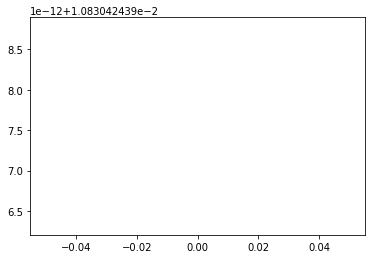

In [26]:
def train_model(train_data,val, model,num_epochs, show = False):
    errors = []
    eval_errors = []
    f1_train = []
    auc_eval = []
    f1_eval =[]
    auc_eval=[]
    num_training_batches = len(train_data)
    batch_size = 64
    optimizer = optim.SGD(model.parameters(),lr= 0.01)    
#     loss_function = nn.NLLLoss()
    loss_function = nn.BCELoss(reduction='none')

    for epoch in range(num_epochs):
        model.train()
        train_iter = iter(train_data)
        model.zero_grad()
        train_loss = 0
        all_preds = []
        all_actual = []
        
        for batch_num in range(num_training_batches):
            batch = next(train_iter)
#             train_batch, class_vector = batch.question_text.transpose(0,1),batch.target.unsqueeze(1)
            targets = batch.target.float()

            optimizer.zero_grad()
            preds = model(batch.question_text)
            loss = loss_function(preds.squeeze(1), targets)


#             loss = loss_function(preds,class_vector)
#             print(preds.shape)
#             print(class_vector.shape)
#             loss = loss_function(preds,class_vector.reshape(64,1).squeeze(1))            
            loss = (loss * (targets*14+1)/(targets*14+1).sum()).sum()
            hard_preds = torch.round(preds)
            all_actual.extend(class_vector.squeeze(-1).tolist())
            all_preds.extend(hard_preds.squeeze(-1).tolist())
            train_loss += loss.item()
            loss.backward()
            print(loss)
            optimizer.step()
#             print(batch_num+1,"out of: ",len(train_data), " With Loss of: ",loss.item()," Acc: ",accuracy, " Best Score of: ", np.asarray(torch.exp(preds))[:,1].max())
            print(batch_num+1,"out of: ",len(train_data), " With Loss of: ",loss.item())
        train_loss_avg = train_loss / (num_training_batches * batch_size)
#         train_confusion_matrix = confusion_matrix(all_actual, all_preds).ravel()
#         f1_train.append(f1_scores(all_actual,all_preds))
#         print("F1 score for epoch {} is {}".format(epoch + 1, f1_train[-1]))
        errors.append(train_loss_avg)
        
        print('VALIDATION SET')
        model.eval()
        val_iter = iter(val)
        num_val_batches = len(val)
#         val_iter = iter(val)
        eval_loss = 0
        all_preds = []
        all_actual = []
        
        with torch.no_grad():
            for batch_num in range(num_val_batches):
                batch = next(val_iter)
                optimizer.zero_grad()

                targets = batch.target.float()
#                 val_batch, class_vector = batch.question_text.transpose(0,1),batch.target.unsqueeze(1)
                preds = model(batch.question_text)
                print(preds.shape)

                loss = loss_function(preds.squeeze(1), targets)


#                 loss = loss_function(preds,class_vector.reshape(64,1).squeeze(1))     
#                 loss = loss_function(preds,class_vector)
                loss = (loss * (targets*14+1)/(targets*14+1).sum()).sum()
                
                hard_preds = torch.round(preds)
                all_preds.extend(hard_preds.squeeze(-1).tolist())
                all_actual.extend(class_vector.squeeze(-1).tolist())
                eval_loss += loss.item()
                print(batch_num+1,"out of: ",len(val), " With Loss of: ",loss.item())


#                 print(batch_num+1,"out of: ",len(train_data), " With Loss of: ",loss.item()," Acc: ",accuracy, " Best Score of: ", np.asarray(torch.exp(preds))[:,1].max())
        eval_loss_avg = eval_loss / (num_val_batches * batch_size)
#         cm = confusion_matrix(all_actual, all_preds).ravel()
#         print("Evaluation F1 score for epoch {} is {}".format(epoch + 1, f1_eval[-1]))
        
        
#         f1_eval.append(f1_score(all_actual,all_preds))
        eval_errors.append(eval_loss_avg)
   
    if show:
        plt.plot(errors)
        plt.plot(eval_errors)
        plt.show()
        
#         plt.plot(f1_train)
#         plt.plot(f1_eval)
#         plt.legend('f1_train','f1_eval')
#         plt.title('Training F1 vs. Validation F1')
#         plt.show()
        
    return
        
        

train_model(train_iter, val_iter, net, 1, show = True )  

In [79]:
print(iter(test_iter).__next__().question_text)
print(len(test))

['have', 'you', 'ever', 'babysitted', 'a', 'child', 'whose', 'parents', 'were', 'abusive?']
375806


In [91]:

batch_size = 10
nb_classes = 2

target = torch.LongTensor(batch_size).random_(nb_classes)
